# Отток клиентов

## Описание проекта

Из «Бета-Банка» каждый месяц стали уходить клиенты.
На основе исторических данных о поведении клиентов нужно построить модель, которая сможет спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

## Обзор и предобработка данных

Импортируем библиотеки.

In [148]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import joblib
from joblib import dump
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score


Создадим датафрейм и посмотрим информацию и первые несколько строк.

In [149]:
try:
    df = pd.read_csv('/datasets/Churn.csv') #создаём датафрейм (с сервера)
except:
    df = pd.read_csv('churn.csv') #создаём датафрейм (с компьютера)

In [150]:
print(df.head(), '\n') # выводим первые 5 строк
df.info() # выводим информацию о датасете
df.duplicated().sum() # выводим количество дубликатов

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

0

Такие данные как ID, фамилия и row number нам не понадобятся для анализа, поэтому эти столбцы можно удалить из датафрейма.
Остальные столбцы приведём к змеиному регистру и проверим данные в каждом столбце на адекватность.

In [151]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1) # удаляем ненужные столбцы из датафрейма

In [152]:
df.columns= df.columns.str.lower() # переводим все названия в нижний регистр

In [153]:
df=df.rename(columns={'creditscore':'credit_score', 'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 
                   'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'}) # переименовываем столбцы
df.head() # выводим первые 5 строк

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Отлично, будем смотреть все столбцы по порядку.

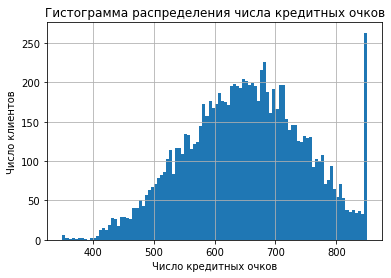

In [154]:
df['credit_score'].hist(bins=100) # строим распределение кредитных очков
plt.xlabel("Число кредитных очков") 
plt.ylabel("Число клиентов")
plt.title("Гистограмма распределения числа кредитных очков") 
plt.show()

Кажется, больше 850 очков никто иметь не может. Но данные без выбросов и аномалий. Столбик на 850 - возможно, какие-то вип-клиенты, которым сразу начислили максимальное число очков.

In [155]:
df['geography'].value_counts() # смотрим, сколько клиентов и из каких они стран

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Всего 3 страны.

In [156]:
df['gender'].value_counts() # смотрим гендерный состав :)

Male      5457
Female    4543
Name: gender, dtype: int64

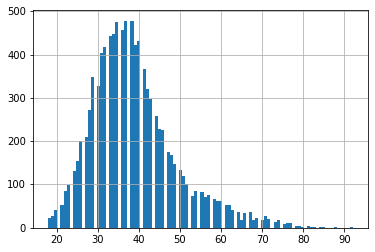

In [157]:
df['age'].hist(bins=100) # строим распределение по возрастам
plt.show()

С возрастом, полом, странами всё в порядке. Идём дальше.

In [158]:
df['tenure'].unique() # смотрим, какие величины есть в столбце tenure

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Попробуем разобраться, почему у некоторых клиентов в tenure пропуски. Сделаем срез по этим строкам.

In [159]:
display(df[df['tenure'].isna()])

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Закономерностей не видно. Попробуем поискать корреляцию tenure с другими признаками.

In [160]:
df.corr() # строим матрицу корреляции признаков в df

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Видно, что сколько-нибудь существенной корреляции у tenure ни с одним из количественных признаков нет. <br> Попробуем сгруппировать tenure по странам и по полу и посмотреть медиану.

In [161]:
df.groupby(['geography'])['tenure'].median() # смотрим медиану срока по разным странам

geography
France     5.0
Germany    5.0
Spain      5.0
Name: tenure, dtype: float64

In [162]:
df.groupby(['gender'])['tenure'].median() # смотрим медиану срока по мужчинам и женщинам

gender
Female    5.0
Male      5.0
Name: tenure, dtype: float64

Зависимости срока от страны или пола клиента тоже нет.
Выведем характеристики исходного распределения и после заполнения пропусков медианой.

In [163]:
df['tenure'].describe() # описание исходного распределения

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [164]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median()) # заполняем пропуски медианой

In [165]:
df['tenure'].describe() # описание нового распределения

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: tenure, dtype: float64

Немного поехали стандартное отклонение и нижняя квартиль. Пока будем считать это приемлемым искажением и оставим в таком виде. <br> При подборе модели будем смотреть, как выглядит иерарархия важности признаков для каждой модели, и где в этой иереархии находится признак tenure.

In [166]:
df.info() # выводим информацию об обновлённом датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


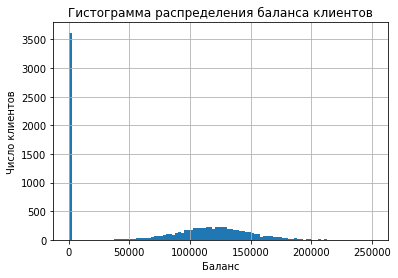

In [167]:
df['balance'].hist(bins=100) # строим распределение по количеству денег на балансе
plt.xlabel("Баланс") 
plt.ylabel("Число клиентов")
plt.title("Гистограмма распределения баланса клиентов") 
plt.show()

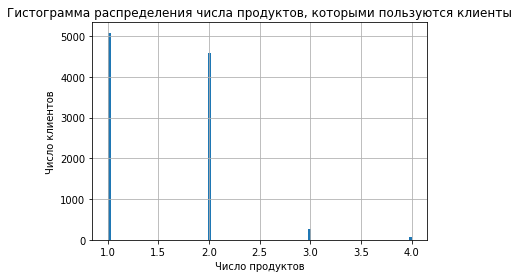

In [168]:
df['num_of_products'].hist(bins=100) # строим распределение по количеству продуктов
plt.xlabel("Число продуктов") 
plt.ylabel("Число клиентов")
plt.title("Гистограмма распределения числа продуктов, которыми пользуются клиенты") 
plt.show()

С балансом и числом продуктов тоже всё понятно, без странностей.

In [169]:
df['has_cr_card'].value_counts() # смотрим, у скольких людей есть кредитная карта

1    7055
0    2945
Name: has_cr_card, dtype: int64

In [170]:
df['is_active_member'].value_counts() # смотрим, сколько активных пользователей

1    5151
0    4849
Name: is_active_member, dtype: int64

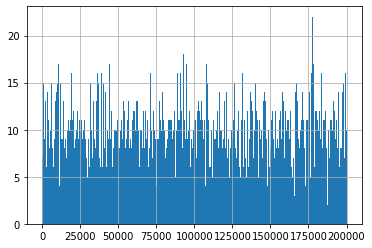

In [171]:
df['estimated_salary'].hist(bins=1000) # строим распределение по величине зарплаты
plt.show()

Такое чувство, что распределение обрезали на значении 200 000.

In [172]:
df['exited'].value_counts() # смотрим, сколько людей ушло из банка

0    7963
1    2037
Name: exited, dtype: int64

Обзор данных показал, что данные практически не нуждаются в предобработке. Везде адекватные значения и заметное число пропусков только в одном столбце. Можно переходить к подготовке наборов для машинного обучения.

## Подготовка данных для машинного обучения




Посмотрим на баланс классов в столбце целевого признака.

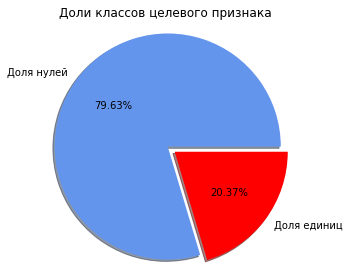

In [173]:
# считаем и выводим доли нулей и единиц в столбце 'exited'
zero_share = df[df['exited'] == 0]['exited'].count()/len(df)
one_share = df[df['exited'] == 1]['exited'].count()/len(df)

# строим круговую диаграмму с долями классов целевого признака
class_share = np.array([zero_share, one_share])
labels = ['Доля нулей', 'Доля единиц']
explode = (0, 0.1)
colors=['cornflowerblue', 'red']
plt.pie(class_share, labels = labels, autopct='%0.2f%%', shadow=True, explode=explode, radius=1.3, colors=colors)
plt.title('Доли классов целевого признака \n')
plt.show()


Налицо дисбаланс. Разобьём датасет на целевой признак и все остальные, их преобразуем с помощью прямого кодирования. Получим обучающую, валидационную и тестовую выборки, которые масштабируем.

In [174]:
target = df['exited'] # извлекаем целевой признак
features = df.drop(['exited'], axis=1) # извлекаем остальные признаки 

# преобразовываем features с помощью прямого кодирования категориальных переменных
features_ohe = pd.get_dummies(features, drop_first=True)

features, features_test, target, target_test = train_test_split(
    features_ohe, target, test_size=.2, random_state=12345, stratify=target) # отделяем 20% данных для тестовой выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.25, random_state=12345, stratify=target) # отделяем 25% оставшихся данных для валидационной выборки

# масштабируем признаки всех выборок с признаками
# делаем датафреймы из массивов с признаками
# перезаписываем индексы в Series с целевым признаком
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_train = pd.DataFrame(features_train, columns=features_ohe.columns)
target_train = target_train.reset_index(drop=True)


features_valid = scaler.transform(features_valid)
features_valid = pd.DataFrame(features_valid, columns=features_ohe.columns)
target_valid = target_valid.reset_index(drop=True)

features_test = scaler.transform(features_test)
features_test = pd.DataFrame(features_test, columns=features_ohe.columns)
target_test = target_test.reset_index(drop=True)

# выводим размер всех наборов
print('Размеры тренировочного набора:', features_train.shape, target_train.shape) # смотрим размеры тренировочного набора
print('Размеры валидационного набора:', features_valid.shape, target_valid.shape) # смотрим размеры валидационного набора
print('Размеры тестового набора:', features_test.shape, target_test.shape) # смотрим размеры тестового набора

Размеры тренировочного набора: (6000, 11) (6000,)
Размеры валидационного набора: (2000, 11) (2000,)
Размеры тестового набора: (2000, 11) (2000,)


Напишем функции для увеличения и уменьшения выборки и применим их к тренировочному набору. 
Так как соотношение признаков примерно 4:1, при увеличении выборки увеличим количество единиц в 4 раза, а при уменьшении оставим 25 % всех нулей, чтобы соотношений было близко к 1:1.

В итоге будеим иметь тенировочных 3 набора: исходный, увеличенный и уменьшенный.

In [175]:
# пишем функцию, которая с помощью копирования строк с целевым признаком 1 увеличит их число в наборе, а затем перемешает строки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
# создаём увеличинный набор из исходного тренировочного
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [176]:
# пишем функцию, которая с помощью удаления части строк с целевым признаком 0 уменьшит их число в наборе, 
# а затем перемешает строки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
# создаём уменьшенный набор из исходного тренировочного
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Посмотрим на размеры получившихся наборов и соотношение классов целевого признака в каждом наборе:


In [177]:
print('Размеры исходного тренировочного набора:', features_train.shape, target_train.shape) # смотрим размеры тренировочного набора
print(target_train.value_counts(), '\n') # смотрим соотношение классов
print('Размеры увеличенного набора:', features_upsampled.shape, target_upsampled.shape) # смотрим размеры увеличенного набора
print(target_upsampled.value_counts(), '\n') # смотрим соотношение классов
print('Размеры уменьшенного набора:', features_downsampled.shape, target_downsampled.shape) # смотрим размеры уменьшенного набора
print(target_downsampled.value_counts(), '\n') # смотрим соотношение классов

Размеры исходного тренировочного набора: (6000, 11) (6000,)
0    4777
1    1223
Name: exited, dtype: int64 

Размеры увеличенного набора: (9669, 11) (9669,)
1    4892
0    4777
Name: exited, dtype: int64 

Размеры уменьшенного набора: (2417, 11) (2417,)
1    1223
0    1194
Name: exited, dtype: int64 



Наши тренировочные наборы готовы, видно, что соотношение классов почти 1:1. Можно приступать к подбору модели.

## Построение модели для классификации

Каждый из тренировочных наборов используем для обучения: 
- дерева решений разной глубины
- случайного леса с разным количеством деревьев разной глубины
- логистическую регрессию

В каждом из случаев будем находить F1-меру для оценки качества, строить ROC-кривую, считать AUC-ROC, строить иерархию важности  признаков. 
<br> Для моделей дерева и леса для построения иерархии используем атрибут feature_importances_, а для модели логистической регрессии о важности признаков будем судить по коэффициентам регрессии.

Функции для построения ROC-кривой, нахождения AUC-ROC, построения иерархии важности признаков для моделей дерева и леса напишем сразу.

In [178]:
# функция для построения ROC-кривой
def ROC_curve(features_valid, target_valid):
    probabilities_valid = best_model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
    plt.figure()
    plt.plot(fpr, tpr)
 # ROC-кривая случайной модели 
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate") 
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая") 
    plt.show()

# функция для нахождения AUC_ROC
def AUC_ROC(features_valid, target_valid):
    probabilities_valid = best_model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]  
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    return auc_roc

# функция для определения иерархии важности признаков для моделей дерева и леса
def importance(model, features):
    importances = pd.DataFrame(data={
    'Признак': features.columns,
    'Важность признака': model.feature_importances_
    }).sort_values(by='Важность признака')
    plt.barh(importances['Признак'], importances['Важность признака'], color='cornflowerblue')
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.title("Важность признаков \n")
    plt.show()

### Дерево решений

Исходный набор 
 f1-мера лучшей модели на валидационной выборке: 0.5747330960854092 
Глубина лучшего дерева: 6


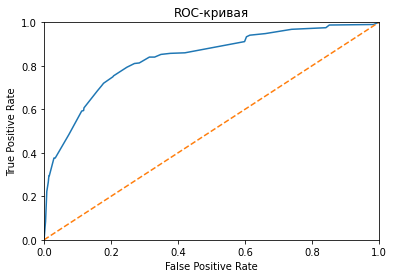

AUC-ROC =  0.8353337929609115 



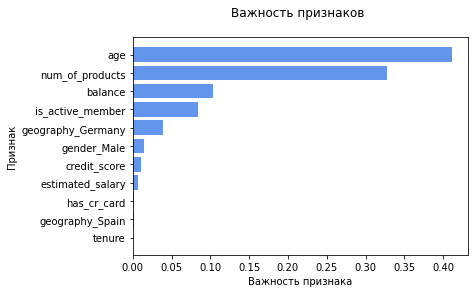

None
Увеличенный набор 
 f1-мера лучшей модели на валидационной выборке: 0.576544315129812 
Глубина лучшего дерева: 6


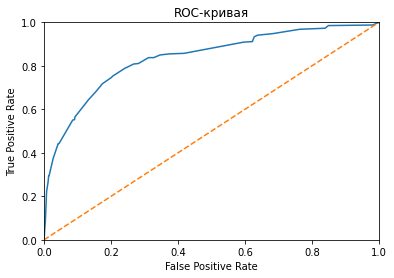

AUC-ROC =  0.8364173109935821 



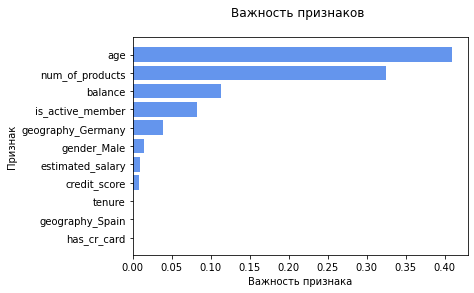

None
Уменьшенный набор 
 f1-мера лучшей модели на валидационной выборке: 0.5933400605449041 
Глубина лучшего дерева: 6


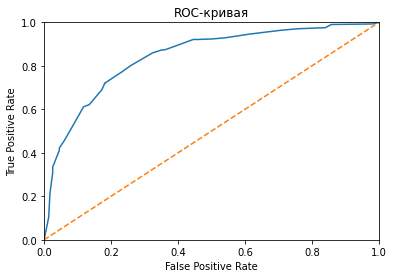

AUC-ROC =  0.8435207164020724 



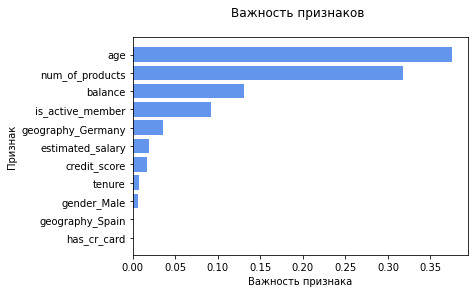

None


In [179]:
# создаём цикл, в котором для исходного, увеличенного и уменьшенного наборов с помощью варьирования глубины
# будет подбираться наилучшее дерево решений
decision_tree_results = []
decision_tree_auc_roc = []
for features, target, name in [[features_train, target_train, 'Исходный набор'], 
                               [features_upsampled, target_upsampled, 'Увеличенный набор'], 
                               [features_downsampled, target_downsampled, 'Уменьшенный набор']]:
    class_weight = 'balanced' if name == 'Исходный набор' else None
    best_model = None
    best_result = 0
    for depth in range(1, 21):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight=class_weight) # создаём модель с заданной глубиной дерева
        model.fit(features, target) # обучаем 
        predicted_valid = model.predict(features_valid)
        result = f1_score(predicted_valid, target_valid) # находим f1-меры на валидационном наборе
        if result > best_result: # с помощью условия находим лучшее дерево и его параметры
            best_model = model # сохраняем лучшую модель
            best_result = result # сохраняем наилучшее значение f1-меры на валидационных данных
            best_depth = depth # глубину лучшего дерева  
    decision_tree_results.append(best_result) # добавляем f1-меру в список
    decision_tree_auc_roc.append(AUC_ROC(features_valid, target_valid)) # добавляем AUC-ROC в список
    print(name, '\n', "f1-мера лучшей модели на валидационной выборке:", best_result, '\nГлубина лучшего дерева:', best_depth) # выводим параметры лучшего дерева    
    # строим ROC-кривую, выводим площадь под ROC-кривой
    ROC_curve(features_valid, target_valid)
    print('AUC-ROC = ', AUC_ROC(features_valid, target_valid), '\n')
    # находим важность признаков
    print(importance(best_model, features))

Для всех трёх наборов оптимально дерево с глубиной 6. По F1-мере и AUC-ROC результаты у уменьшенной выборки чуть лучше, чем у остальных, но в целом довольно близкие значения.

### Случайный лес

Исходный набор 
 f1-мера наилучшей модели на валидационной выборке: 0.624413145539906 
Лучшая глубина дерева: 9 
Лучшее количество деревьев: 16 



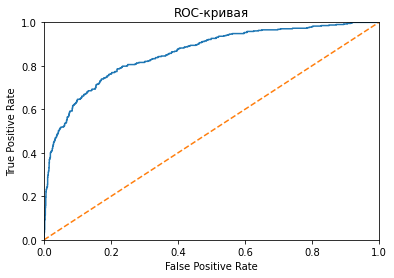

AUC-ROC =  0.8581393411901885 



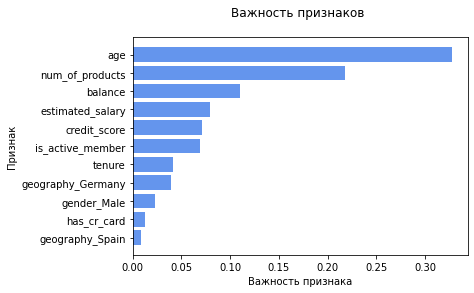

None
Увеличенный набор 
 f1-мера наилучшей модели на валидационной выборке: 0.6328042328042327 
Лучшая глубина дерева: 9 
Лучшее количество деревьев: 18 



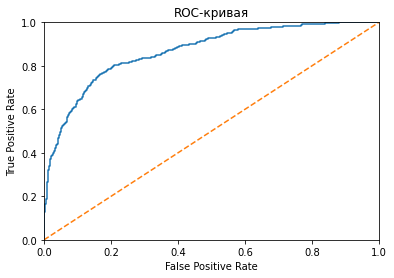

AUC-ROC =  0.8670565789209858 



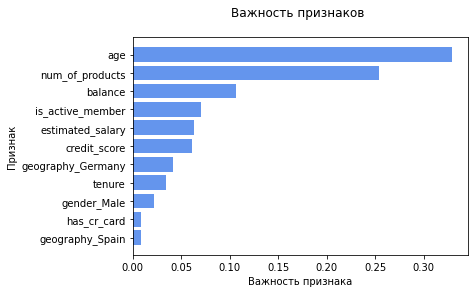

None
Уменьшенный набор 
 f1-мера наилучшей модели на валидационной выборке: 0.6168958742632613 
Лучшая глубина дерева: 8 
Лучшее количество деревьев: 15 



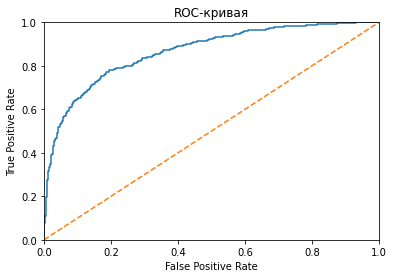

AUC-ROC =  0.8656021198394079 



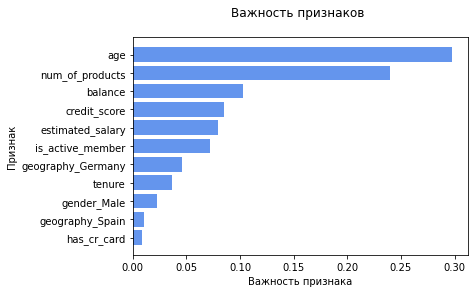

None
CPU times: user 1min 2s, sys: 273 ms, total: 1min 2s
Wall time: 1min 2s


In [180]:
%%time

# создаём цикл, в котором для исходного, увеличенного и уменьшенного наборов с помощью варьирования глубины и числа деревьев
# будет подбираться наилучший случайный лес
random_forest_results = []
random_forest_auc_roc = []
for features, target, name in [[features_train, target_train, 'Исходный набор'], 
                               [features_upsampled, target_upsampled, 'Увеличенный набор'], 
                               [features_downsampled, target_downsampled, 'Уменьшенный набор']]:
    class_weight = 'balanced' if name == 'Исходный набор' else None
    best_result = 0
    for est in range(1, 21):
        for depth in range(1, 21):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, 
                                           max_depth=depth, class_weight=class_weight) # создаём модель с заданным количеством деревьев
            model.fit(features, target) # обучаем модель на тренировочной выборке
            predicted_valid = model.predict(features_valid)
            result = f1_score(predicted_valid, target_valid) # находим f1-меру на валидационном наборе
            if result > best_result:
                best_model = model # сохраняем лучшую модель
                best_result = result #  сохраняем наилучшее значение f1-меру на валидационных данных
                best_est = est
                best_depth = depth
    random_forest_results.append(best_result) # добавляем f1-меру в список, чтобы потом представить результаты в виде таблицы
    random_forest_auc_roc.append(AUC_ROC(features_valid, target_valid)) # добавляем AUC-ROC в список
    # Выводим параметры лучшего леса
    print(name, '\n', "f1-мера наилучшей модели на валидационной выборке:", best_result, 
          '\nЛучшая глубина дерева:', best_depth, 
          '\nЛучшее количество деревьев:', best_est, '\n')
    ROC_curve(features_valid, target_valid)
    # строим ROC-кривую, выводим площадь под ROC-кривой
    print('AUC-ROC = ', AUC_ROC(features_valid, target_valid), '\n')
    # находим важность признаков
    print(importance(best_model, features))

Снова близкие результаты, лучше всего F1-мера и AUC-ROC у леса из 18 деревьев с глубиной 9, тренировавшегося на увеличенном наборе.

### Логистическая регрессия

Исходный набор
f1-мера модели на валидационной выборке: 0.5113043478260869 



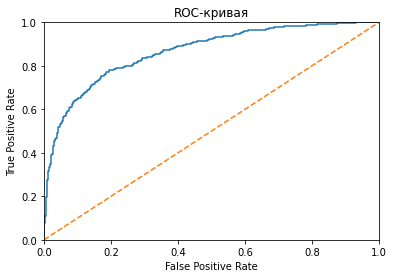

AUC-ROC =  0.8656021198394079 



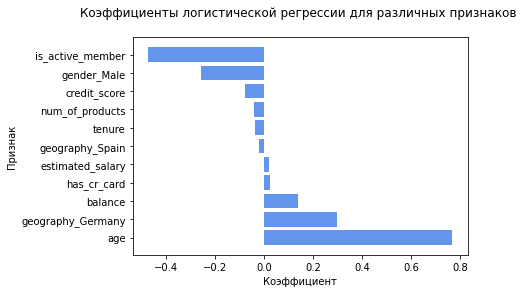

Увеличенный набор
f1-мера модели на валидационной выборке: 0.5068493150684932 



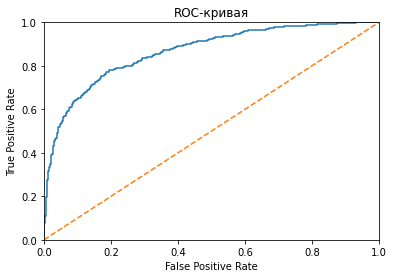

AUC-ROC =  0.8656021198394079 



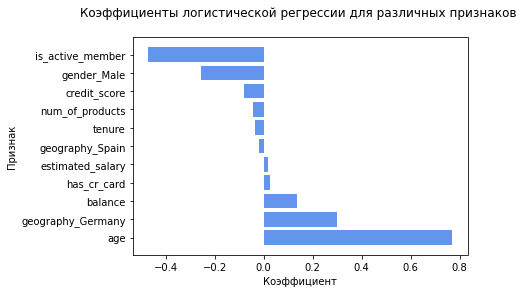

Уменьшенный набор
f1-мера модели на валидационной выборке: 0.5042881646655232 



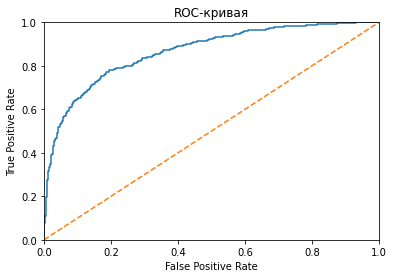

AUC-ROC =  0.8656021198394079 



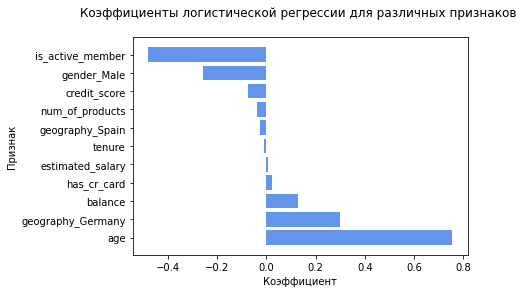

In [181]:
# создаём цикл, в котором на исходном, увеличенном и уменьшенном наборах будет опробована модель логистической регрессии
logistic_regression_results = []
logistic_regression_auc_roc = []
for features, target, name in [[features_train, target_train, 'Исходный набор'], 
                               [features_upsampled, target_upsampled, 'Увеличенный набор'], 
                               [features_downsampled, target_downsampled, 'Уменьшенный набор']]:
    class_weight = 'balanced' if name == 'Исходный набор' else None
    model = LogisticRegression(random_state=12345, max_iter=1000, solver='liblinear',
                              class_weight=class_weight) # строим модель логистической регрессии
    model.fit(features, target) # обучаем модель на тренировочной выборке
# находим и вывадим f1-меру на валидационном наборе
    predicted_valid = model.predict(features_valid)
    result = f1_score(predicted_valid, target_valid)
    print(name)
    print("f1-мера модели на валидационной выборке:", result, '\n') 
    logistic_regression_results.append(result) # добавляем f1-меру в список
    logistic_regression_auc_roc.append(AUC_ROC(features_valid, target_valid)) # добавляем AUC-ROC в список
    # строим ROC-кривую, выводим площадь под ROC-кривой
    ROC_curve(features_valid, target_valid)
    print('AUC-ROC = ', AUC_ROC(features_valid, target_valid), '\n')
    # находим важность признаков
    importances = pd.DataFrame(data={
    'Признак': features.columns,
    'Коэффициент': model.coef_[0]
    }).sort_values(by='Коэффициент', ascending=False)
    plt.barh(importances['Признак'], importances['Коэффициент'], color='cornflowerblue')
    plt.ylabel("Признак")
    plt.xlabel("Коэффициент")
    plt.title("Коэффициенты логистической регрессии для различных признаков \n")
    plt.show()

Сделаем свобную таблицу с результатами.

In [182]:
# Создаём таблицу с F1-мерами и AUC-ROC для всех моделей и наборов
result_f1 = pd.DataFrame(data={'Дерево решений':decision_tree_results, 
                               'Случайный лес':random_forest_results, 
                               'Логистическая регрессия':logistic_regression_results},
                                index=['Исходный набор', 'Увеличенный набор', 'Уменьшенный набор'])

result_auc_roc = pd.DataFrame(data={'Дерево решений':decision_tree_auc_roc, 
                               'Случайный лес':random_forest_auc_roc, 
                               'Логистическая регрессия':logistic_regression_auc_roc},
                               index=['Исходный набор', 'Увеличенный набор', 'Уменьшенный набор'])

result_all = result_f1.join(result_auc_roc, lsuffix='_f1', rsuffix='_auc_roc')

# Выводим таблицу
display(result_all)

,Дерево решений_f1,Случайный лес_f1,Логистическая регрессия_f1,Дерево решений_auc_roc,Случайный лес_auc_roc,Логистическая регрессия_auc_roc
Исходный набор,0.574733,0.624413,0.511304,0.835334,0.858139,0.865602
Увеличенный набор,0.576544,0.632804,0.506849,0.836417,0.867057,0.865602
Уменьшенный набор,0.593340,0.616896,0.504288,0.843521,0.865602,0.865602


 Наибольшее значение F1-меры у модели случайного леса из 18 деревьев с глубиной 9, тренировавшегося на увеличенном наборе, выбираем эту модель для тестрования. <br> У логистической регрессии самые маленькие F1-меры. Интересно, что F1-меры изменяются не синхронно с AUC-ROC - если F1-мера одной модели больше, чем у другой, это не значит, что их AUC-ROC будут в таком отношении. 

## Тестирование лучшей модели

Пересоздадим модель с самой большой F1-мерой:

In [183]:
# пересоздаём модель случайного леса
model = RandomForestClassifier(random_state=12345, n_estimators=18, max_depth=9) 
model.fit(features_upsampled, target_upsampled) # обучаем модель на увеличенной тренировочной выборке
predicted_valid = model.predict(features_valid) # делаем предсказание для валидационной выборки
print('F1-мера лучшей модели (валидационный набор): ', f1_score(predicted_valid, target_valid)) # находим f1-меру на валидационном наборе

F1-мера лучшей модели (валидационный набор):  0.6328042328042327


Протестируем модель:

In [184]:
predicted_test = model.predict(features_test) # делаем предсказание для тестовой выборки
print('F1-мера лучшей модели (тестовый набор): ', f1_score(predicted_test, target_test)) # находим f1-меру на тестовом наборе

F1-мера лучшей модели (тестовый набор):  0.6099893730074389


In [185]:
joblib.dump(model, 'best_model') # сохраним нашу модель

['best_model']

## Дополнительный анализ

Построение иерархии признаков для моделей с наиболее высокой f1-мерой показал, что на факт ухода больше всего влияют возраст и число продуктов. Попробуем исследовать эти зависимости. <br> Начнём с влияния возраста на факт ухода. Разобьём всех клиентов на возрастные категории, а потом посмотрим процент уходов среди представителей каждой категории.

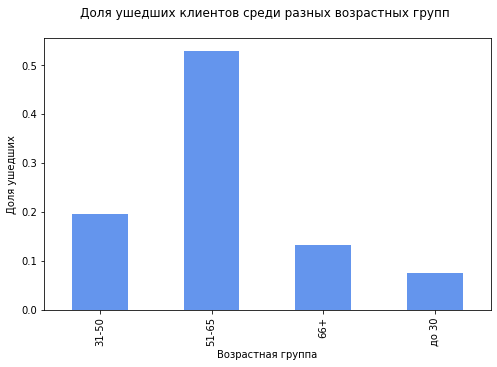

In [201]:
def age_grouping(age): # пишем функцию, которая на входе получает возраст, а возвращает возрастную категорию
    if age <= 30:
        return 'до 30'
    elif age <= 50:
        return '31-50'
    elif age <= 65:
        return '51-65'
    else:
        return '66+'
df['age_category'] = df['age'].apply(age_grouping) # создаём в датафрейме столбец с возрастной категорией
# Строим зависимость доли ушедших клиентов от возрастной группы
df.groupby('age_category')['exited'].mean().plot.bar(color='cornflowerblue', alpha=1, figsize=(8, 5))
plt.ylabel("Доля ушедших")
plt.xlabel("Возрастная группа")
plt.title("Доля ушедших клиентов среди разных возрастных групп \n")
plt.show()

Активнее всего уходят клиенты в возрасте 51-65 лет. 
<br> Исследуем зависимость от числа продуктов.

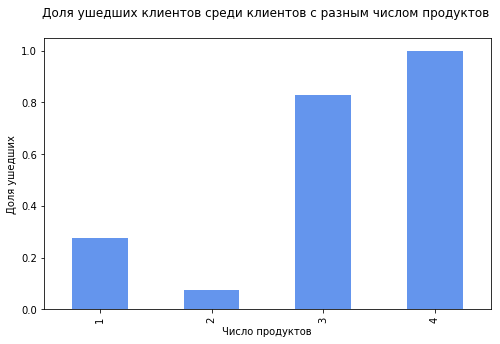

In [202]:
# Строим зависимость доли ушедших клиентов от числа продуктов
df.groupby('num_of_products')['exited'].mean().plot.bar(color='cornflowerblue', alpha=1, figsize=(8, 5))
plt.ylabel("Доля ушедших")
plt.xlabel("Число продуктов")
plt.title("Доля ушедших клиентов среди клиентов с разным числом продуктов \n")
plt.show()

In [198]:
# выводим зависимость доли ушедших клиентов от числа продуктов в виде таблицы
display(df.groupby('num_of_products')['exited'].mean()) 

num_of_products
1    0.277144
2    0.075817
3    0.827068
4    1.000000
Name: exited, dtype: float64

Удивительно, 82,7% обладателей 3 продуктов и все, у кого было 4 продукта, ушли.

## Выводы

1. Мы подобрали модель, которая позволит прогнозировать скорый ухода клиента из банка
2. Теперь банк, используя её, сможет предупредить этот уход, например, сделав клиенту выгодное прдложение
3. Построив иерархию важности признаков для моделей, мы выяснили, что больше всего (по мнению дерева решений и случайного леса) на уход влияют возраст и количество продуктов. Стоит обратить внимание на высокий процент уходов среди клиентов от 51 до 65 лет, а также клиентов с 3 и 4 продуктами.